In [2]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.Classify import SklearnClassifier
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
# from tkinter import *

In [22]:
nltk.download('punkt')
nltk.download('popular')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_rev

True

In [7]:
header = ['target', 'id', 'date', 'flag', 'user', 'tweet']

df = pd.read_csv('training.1600000.processed.noemoticon.csv', names=header, header=None, encoding='latin-1')
df

,target,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [25]:
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


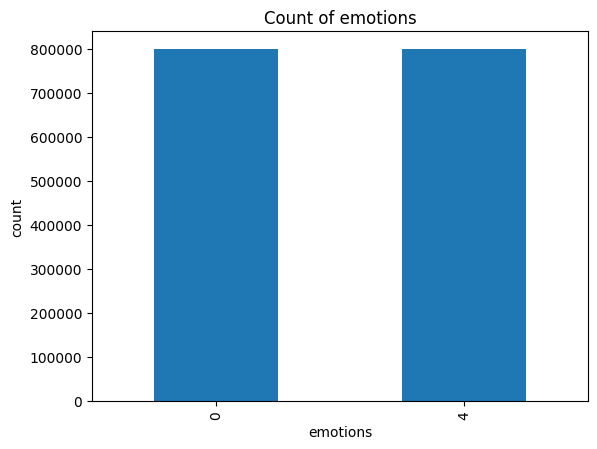

In [26]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

Taking one of the tweet as an example

In [65]:
example = df['tweet'][1019].lower()
print(example)

@kal_penn you were pretty much my fave...not much reason to watch now 


## Tokenize words

In [66]:
raw_token = word_tokenize(example)
raw_token

['@',
 'kal_penn',
 'you',
 'were',
 'pretty',
 'much',
 'my',
 'fave',
 '...',
 'not',
 'much',
 'reason',
 'to',
 'watch',
 'now']

## Feature Engineering

In [81]:
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords_removed_token = [w for w in raw_token if not w in stopwords]

# token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

def clean_words(words):
    stopwords_removed_token = [w for w in words if not w in stopwords]
    token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

    return token

clean_df = df


for i, row in clean_df.iterrows():
    clean_df['tweet'][i] = row['tweet'].lower()

clean_df['tweet'] = clean_words(clean_df['tweet'])
# stemmed_token = [PorterStemmer().stem(w) for w in lemmed_token]
# stemmed_token

clean_df.head(100)

/tmp/ipykernel_118835/1594963226.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['tweet'][i] = row['tweet'].lower()


KeyboardInterrupt: 

In [75]:
tag = nltk.pos_tag(token)
tag

[('@', 'JJ'),
 ('kal_penn', 'VB'),
 ('pretty', 'RB'),
 ('much', 'JJ'),
 ('fave', 'VBP'),
 ('...', ':'),
 ('much', 'JJ'),
 ('reason', 'NN'),
 ('watch', 'NN')]

chunking the tag

In [76]:
chunk = nltk.chunk.ne_chunk(tag)
chunk.pprint()
# chunk.draw()

# chunkGram = r"""Chunk: {<RB.?>*<VB.?>*<NNP><NN>?}"""
# chunkParser = nltk.RegexpParser(chunkGram)
# chunked = chunkParser.parse(tag)
# chunked

(S
  @/JJ
  kal_penn/VB
  pretty/RB
  much/JJ
  fave/VBP
  .../:
  much/JJ
  reason/NN
  watch/NN)


In [77]:
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in df.iterrows():
    tweet = row['tweet']
    Id = row['id']
    res[Id] = sia.polarity_scores(tweet)

# polarity_score = sia.polarity_scores(example)

# plt.bar(list(polarity_score.keys()), list(polarity_score.values()))
# plt.show()

KeyboardInterrupt: 

In [98]:
vaders = pd.DataFrame(res)
# vaders = vaders.reset_index().rename(columns={'index': 'id'})
# vaders = vaders.merge(df, how='left')
vaders.head(10)

,1467810369,1467810672,1467810917,1467811184,1467811193,1467811372,1467811592,1467811594,1467811795,1467812025,...,2193579249,2193579284,2193579434,2193579477,2193579489,2193601966,2193601969,2193601991,2193602064,2193602129
neg,0.1290,0.303,0.0000,0.321,0.2410,0.0,0.0000,0.093,0.0,0.0,...,0.0,0.1690,0.0,0.0,0.0000,0.1380,0.0000,0.0000,0.0000,0.0000
neu,0.7450,0.697,0.8330,0.500,0.7590,1.0,0.2440,0.548,1.0,1.0,...,1.0,0.8310,1.0,1.0,0.7240,0.5030,0.7570,0.8000,0.7060,0.5190
pos,0.1260,0.000,0.1670,0.179,0.0000,0.0,0.7560,0.359,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.2760,0.3580,0.2430,0.2000,0.2940,0.4810
compound,-0.0173,-0.750,0.4939,-0.250,-0.6597,0.0,0.4767,0.745,0.0,0.0,...,0.0,-0.6467,0.0,0.0,0.7906,0.5423,0.4376,0.3612,0.6784,0.5719


In [42]:
tweets_neg_token = []
tweets_pos_token = []

for i, row in df.iterrows():
    row['tweet'] = row
    if row['target'] == 0:
        tweets_neg_token.extend(word_tokenize(row['tweet']))
    elif row['target'] == 4:
        tweets_pos_token.extend(word_tokenize(row['tweet']))

all_neg_words = nltk.FreqDist(tweets_neg_token)
print(all_neg_words)

<FreqDist with 474557 samples and 13289587 outcomes>


In [41]:
word_features = list(all_words.keys())[:4800000]
word_features

['@',
 'switchfoot',
 'http',
 ':',
 '//twitpic.com/2y1zl',
 '-',
 'Awww',
 ',',
 'that',
 "'s",
 'a',
 'bummer',
 '.',
 'You',
 'shoulda',
 'got',
 'David',
 'Carr',
 'of',
 'Third',
 'Day',
 'to',
 'do',
 'it',
 ';',
 'D',
 'is',
 'upset',
 'he',
 'ca',
 "n't",
 'update',
 'his',
 'Facebook',
 'by',
 'texting',
 '...',
 'and',
 'might',
 'cry',
 'as',
 'result',
 'School',
 'today',
 'also',
 'Blah',
 '!',
 'Kenichan',
 'I',
 'dived',
 'many',
 'times',
 'for',
 'the',
 'ball',
 'Managed',
 'save',
 '50',
 '%',
 'The',
 'rest',
 'go',
 'out',
 'bounds',
 'my',
 'whole',
 'body',
 'feels',
 'itchy',
 'like',
 'its',
 'on',
 'fire',
 'nationwideclass',
 'no',
 'not',
 'behaving',
 'at',
 'all',
 'i',
 "'m",
 'mad',
 'why',
 'am',
 'here',
 '?',
 'because',
 'see',
 'you',
 'over',
 'there',
 'Kwesidei',
 'crew',
 'Need',
 'hug',
 'LOLTrish',
 'hey',
 'long',
 'time',
 'Yes',
 '..',
 'Rains',
 'bit',
 'only',
 'LOL',
 'fine',
 'thanks',
 'how',
 'Tatiana_K',
 'nope',
 'they',
 'did',
 '